# Реализация алгоритмов

## Импорт необходимых библиотек

In [1]:
import sys

sys.path.insert(1, "../")

import os
import pathlib
import collections

import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    make_scorer,
)
import mahotas

from src.data.dataset_filenames import extract_type_face
from src.data.utils import is_non_zero_file, get_directory_file_list, resize_img
from src.features import (
    haralick_rdwt_features,
    dispersion_feature,
    mean_feature,
    median_feature,
    maximum_feature,
    minimum_feature,
    fraction_pixels_for_interval_feature,
    scatter_feature,
    hist_feauture,
    hist_gradient_feauture,
    ratio_upper_lower_parts_feature,
    haralick_rdwt_features_with_blockwise,
    get_blocks,
    calc_and_get_haralick,
    lbp_hist_features,
    calc_features,
)
from src.features.utils import apply_feature_funcs


%matplotlib inline

## Загрузка изображений лиц

In [2]:
path_to_dataset = pathlib.Path(
    pathlib.Path.home(),
    "Projects",
    "ml",
    "datasets",
    "FACE_ANTISPOOFING",
    "FACE_ANTISPOOFING_FACES",
)
path_to_dataset_rgb_faces = path_to_dataset / "rgb"
path_to_dataset_th_faces = path_to_dataset / "thermal"

### Функция для загрузки изображений датасета с мета-информацией

In [3]:
def load_dataset_objects(path, img_size=(312, 312), cv_mode=cv2.COLOR_BGR2RGB):
    result = {"filenames": [], "images": [], "subclasses": [], "classes": []}

    for root, dirs, files in os.walk(path):
        for filename in files:
            if not filename.startswith("."):
                result["filenames"].append(filename)

                image = cv2.imread(os.path.join(root, filename))
                image = cv2.cvtColor(image, cv_mode)
                image = resize_img(image, img_size)
                result["images"].append(image)

                result["subclasses"].append(extract_type_face(filename))
                result["classes"].append(int("a" in result["subclasses"][-1]))

    return result

## Загрузка RGB-изображений лиц

In [4]:
rgb_data = load_dataset_objects(path_to_dataset_rgb_faces)

## Загрузка тепловых изображений лиц

In [5]:
th_data = load_dataset_objects(path_to_dataset_th_faces, cv_mode=cv2.COLOR_BGR2GRAY)

## Сортировка загруженных данных

In [6]:
rgb_sorted_indices = np.argsort(rgb_data["filenames"])
rgb_data["filenames"] = np.array(rgb_data["filenames"])[rgb_sorted_indices]
rgb_data["images"] = np.array(rgb_data["images"])[rgb_sorted_indices]
rgb_data["classes"] = np.array(rgb_data["classes"])[rgb_sorted_indices]

th_sorted_indices = np.argsort(th_data["filenames"])
th_data["filenames"] = np.array(th_data["filenames"])[th_sorted_indices]
th_data["images"] = np.array(th_data["images"])[th_sorted_indices]
th_data["classes"] = np.array(th_data["classes"])[th_sorted_indices]

classes = rgb_data["classes"].copy()

## Пример одного образца из датасета

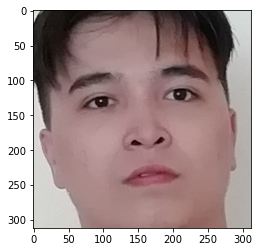

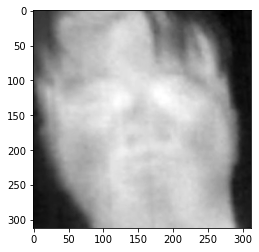

In [7]:
plt.imshow(rgb_data["images"][52])
plt.show()
plt.imshow(th_data["images"][52], cmap="gray")
plt.show()

## Метрики

In [8]:
def BPCER_score(y_true, y_pred):
    y_true = y_true.astype(np.bool_)
    y_pred = y_pred.astype(np.bool_)
    return sum(y_pred & ~y_true) / len(y_true[np.where(y_true == False)])


def APCER_score(y_true, y_pred):
    y_true = y_true.astype(np.bool_)
    y_pred = y_pred.astype(np.bool_)
    return sum(~y_pred & y_true) / len(y_true[np.where(y_true == True)])


def ACER_score(y_true, y_pred):
    APCER = APCER_score(y_true, y_pred)
    BPCER = BPCER_score(y_true, y_pred)
    ACER = (APCER + BPCER) / 2
    return ACER

### Функция, возвращающая значения различных метрик

In [9]:
def get_metric_values(y_true, y_pred, pos_label=1):
    return {
        "APCER": APCER_score(y_true, y_pred),
        "BPCER": BPCER_score(y_true, y_pred),
        "ACER": ACER_score(y_true, y_pred),
        "AUC ROC": roc_auc_score(
            y_true,
            y_pred,
            average="weighted",
        ),
        "Precision": precision_score(
            y_true, y_pred, average="binary", pos_label=pos_label
        ),
        "Recall": recall_score(y_true, y_pred, average="binary", pos_label=pos_label),
        "F1-Measure": f1_score(y_true, y_pred, average="binary", pos_label=pos_label),
    }

In [28]:
path_to_metrics_result = "../reports/tables/metrics_report.csv"

In [11]:
if os.path.exists(path_to_metrics_result):
    measured_metrics = pd.read_csv(path_to_metrics_result)
else:
    measured_metrics = pd.DataFrame(
        {
            "Metric": [
                "APCER",
                "BPCER",
                "ACER",
                "AUC ROC",
                "Precision",
                "Recall",
                "F1-Measure",
            ]
        }
    )

In [12]:
measured_metrics.head()

,Metric
0,APCER
1,BPCER
2,ACER
3,AUC ROC
4,Precision


## Разбиение набора данных на тренировочную и тестовую выборки

In [15]:
# X = []
# y = classes.copy()

# for rgb_img, th_img in zip(rgb_data["images"], th_data["images"]):
#     X.append({"rgb": rgb_img, "thermal": th_img})

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Алгоритм RGB-RDWT-Haralick-SVM with block-wise

In [15]:
X = []
y = classes.copy()

for img in rgb_data["images"]:
    X.append(
        calc_features(
            [img[:, :, 0], img[:, :, 1], img[:, :, 2]], [haralick_rdwt_features], 9
        )
    )

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid_rgb_rdwt_haralick_svc = GridSearchCV(
    estimator=SVC(),
    scoring="precision",
    param_grid={
        "C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
        "kernel": ("linear", "rbf"),
    },
)

grid_rgb_rdwt_haralick_svc.fit(X_train, y_train)

print("Best estimator: ", grid_rgb_rdwt_haralick_svc.best_estimator_)

y_pred = grid_rgb_rdwt_haralick_svc.predict(X_test)

measured_metrics["RGB-RDWT-Haralick-SVM"] = get_metric_values(y_test, y_pred).values()

## Алгоритм Thermal-RDWT-Haralick-SVM with block-wise

In [16]:
X = []
y = classes.copy()

for img in th_data["images"]:
    X.append(calc_features([img], [haralick_rdwt_features], 9))

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid_th_rdwt_haralick_svc = GridSearchCV(
    estimator=SVC(),
    scoring="precision",
    param_grid={
        "C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
        "kernel": ("linear", "rbf"),
    },
)

grid_th_rdwt_haralick_svc.fit(X_train, y_train)

print("Best estimator: ", grid_th_rdwt_haralick_svc.best_estimator_)

y_pred = grid_th_rdwt_haralick_svc.predict(X_test)

measured_metrics["Thermal-RDWT-Haralick-SVM"] = get_metric_values(
    y_test, y_pred
).values()

## Алгоритм MC(RGB+Thermal)-RDWT-Haralick-SVM with block-wise

In [17]:
X = []
y = classes.copy()

for rgb_img, th_img in zip(rgb_data["images"], th_data["images"]):
    X.append(
        calc_features(
            [rgb_img[:, :, 0], rgb_img[:, :, 1], rgb_img[:, :, 2], th_img],
            [haralick_rdwt_features],
            9,
        )
    )

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid_mc_rdwt_haralick_svc = GridSearchCV(
    estimator=SVC(),
    scoring="precision",
    param_grid={
        "C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
        "kernel": ("linear", "rbf"),
    },
)

grid_mc_rdwt_haralick_svc.fit(X_train, y_train)

print("Best estimator: ", grid_mc_rdwt_haralick_svc.best_estimator_)

y_pred = grid_mc_rdwt_haralick_svc.predict(X_test)

measured_metrics["MC-RDWT-Haralick-SVM"] = get_metric_values(y_test, y_pred).values()

## Алгоритм Grayscale(RGB)-LBP-SVM

In [120]:
X = []
y = classes.copy()

for img in rgb_data["images"]:
    gray_rgb_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    X.append(calc_features([gray_rgb_img], [lbp_hist_features], 9))

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid_gsrgb_lbp_svc = GridSearchCV(
    estimator=SVC(),
    scoring="precision",
    param_grid={
        "C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
        "kernel": ("linear", "rbf"),
    },
)

grid_gsrgb_lbp_svc.fit(X_train, y_train)

print("Best estimator: ", grid_gsrgb_lbp_svc.best_estimator_)

y_pred = grid_gsrgb_lbp_svc.predict(X_test)

measured_metrics["Grayscale(RGB)-LBP-SVM"] = get_metric_values(y_test, y_pred).values()

## Алгоритм RGB-LBP-SVM

In [ ]:
X = []
y = classes.copy()

for rgb_img in rgb_data["images"]:
    X.append(
        calc_features(
            [rgb_img[:, :, 0], rgb_img[:, :, 1], rgb_img[:, :, 2]],
            [lbp_hist_features],
            9,
        )
    )

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid_rgb_lbp_svc = GridSearchCV(
    estimator=SVC(),
    scoring="precision",
    param_grid={
        "C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
        "kernel": ("linear", "rbf"),
    },
)

grid_rgb_lbp_svc.fit(X_train, y_train)

print("Best estimator: ", grid_rgb_lbp_svc.best_estimator_)

y_pred = grid_rgb_lbp_svc.predict(X_test)

measured_metrics["RGB-LBP-SVM"] = get_metric_values(y_test, y_pred).values()

## Алгоритм Thermal-LBP-SVM

In [114]:
X = []
y = classes.copy()

for img in th_data["images"]:
    X.append(calc_features([img], [lbp_hist_features], 9))

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid_th_lbp_svc = GridSearchCV(
    estimator=SVC(),
    scoring="precision",
    param_grid={
        "C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
        "kernel": ("linear", "rbf"),
    },
)

grid_th_lbp_svc.fit(X_train, y_train)

print("Best estimator: ", grid_th_lbp_svc.best_estimator_)

y_pred = grid_th_lbp_svc.predict(X_test)

measured_metrics["Thermal-LBP-SVM"] = get_metric_values(y_test, y_pred).values()

## Алгоритм MC(RGB+Thermal)-LBP-SVM

In [123]:
X = []
y = classes.copy()

for rgb_img, th_img in zip(rgb_data["images"], th_data["images"]):
    X.append(
        calc_features(
            [rgb_img[:, :, 0], rgb_img[:, :, 1], rgb_img[:, :, 2], th_img],
            [lbp_hist_features],
            9,
        )
    )

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid_mc_lbp_svc = GridSearchCV(
    estimator=SVC(),
    scoring="precision",
    param_grid={
        "C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
        "kernel": ("linear", "rbf"),
    },
)

grid_mc_lbp_svc.fit(X_train, y_train)

print("Best estimator: ", grid_mc_lbp_svc.best_estimator_)

y_pred = grid_mc_lbp_svc.predict(X_test)

measured_metrics["MC-LBP-SVM"] = get_metric_values(y_test, y_pred).values()

## Алгоритм Grayscale(RGB)-TAS-SVM with block-wise

In [35]:
feature_funcs = [mahotas.features.tas]

X = []
y = classes.copy()

for rgb_img, th_img in zip(rgb_data["images"], th_data["images"]):
    gray_rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    X.append(calc_features([gray_rgb_img], feature_funcs, 9))

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid_gsrgb_tas_svc = GridSearchCV(
    estimator=SVC(),
    scoring="precision",
    param_grid={
        "C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
        "kernel": ("linear", "rbf"),
    },
)
grid_gsrgb_tas_svc.fit(X_train, y_train)

print("Best estimator: ", grid_gsrgb_tas_svc.best_estimator_)

y_pred = grid_gsrgb_tas_svc.predict(X_test)

measured_metrics["Grayscale(RGB)-TAS-SVM"] = get_metric_values(y_test, y_pred).values()

## Алгоритм RGB-TAS-SVM with block-wise

In [41]:
feature_funcs = [mahotas.features.tas]

X = []
y = classes.copy()

for rgb_img, th_img in zip(rgb_data["images"], th_data["images"]):
    X.append(
        calc_features(
            [rgb_img[:, :, 0], rgb_img[:, :, 1], rgb_img[:, :, 2]], feature_funcs, 9
        )
    )

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid_rgb_tas_svc = GridSearchCV(
    estimator=SVC(),
    scoring="precision",
    param_grid={
        "C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
        "kernel": ("linear", "rbf"),
    },
)

grid_rgb_tas_svc.fit(X_train, y_train)

print("Best estimator: ", grid_rgb_tas_svc.best_estimator_)

y_pred = grid_rgb_tas_svc.predict(X_test)

measured_metrics["RGB-TAS-SVM"] = get_metric_values(y_test, y_pred).values()

## Алгоритм Thermal-TAS-SVM with block-wise

In [56]:
feature_funcs = [mahotas.features.tas]

X = []
y = classes.copy()

for rgb_img, th_img in zip(rgb_data["images"], th_data["images"]):
    X.append(calc_features([th_img], feature_funcs, 9))

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid_th_tas_svc = GridSearchCV(
    estimator=SVC(),
    scoring="precision",
    param_grid={
        "C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
        "kernel": ("linear", "rbf"),
    },
)

grid_th_tas_svc.fit(X_train, y_train)

print("Best estimator: ", grid_th_tas_svc.best_estimator_)

y_pred = grid_th_tas_svc.predict(X_test)

measured_metrics["Thermal-TAS-SVM"] = get_metric_values(y_test, y_pred).values()

## Алгоритм MC-TAS-SVM with block-wise

In [21]:
feature_funcs = [mahotas.features.tas]

X = []
y = classes.copy()

for rgb_img, th_img in zip(rgb_data["images"], th_data["images"]):
    gray_rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    X.append(
        calc_features(
            channels=[rgb_img[:, :, 0], rgb_img[:, :, 1], rgb_img[:, :, 2], th_img],
            feature_funcs=feature_funcs,
            blockwise=9,
        )
    )

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

grid_mc_tas_svc = GridSearchCV(
    estimator=SVC(),
    scoring="precision",
    param_grid={
        "C": [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
        "kernel": ("linear", "rbf"),
    },
)
grid_mc_tas_svc.fit(X_train, y_train)

print("Best estimator: ", grid_mc_tas_svc.best_estimator_)

y_pred = grid_mc_tas_svc.predict(X_test)

measured_metrics["MC-TAS-SVM"] = get_metric_values(y_test, y_pred).values()

In [20]:
measured_metrics

,Metric,MC-TAS-SVM
0,APCER,0.0
1,BPCER,0.0
2,ACER,0.0
3,AUC ROC,1.0
4,Precision,1.0
5,Recall,1.0
6,F1-Measure,1.0


In [29]:
measured_metrics.to_csv(path_to_metrics_result)